Saliency Maps (Картирование важности пикселей)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 152MB/s]


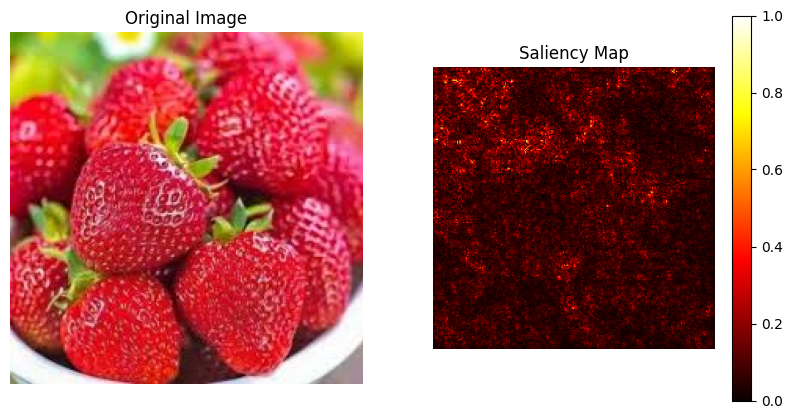

In [ ]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Загрузка предобученной модели
model = models.resnet18(pretrained=True)
model.eval()  # Переключаем в режим оценки

# Преобразования для изображения
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Загрузка изображения
image = Image.open("/content/клубничке.jpg")  # Замените на свой путь
input_tensor = preprocess(image).unsqueeze(0)
input_tensor.requires_grad = True  # Включаем градиенты для входного тензора

# Прямой проход
output = model(input_tensor)
pred_class = output.argmax(dim=1).item()

# Обратный проход для целевого класса
model.zero_grad()
output[0, pred_class].backward()

# Получение градиентов входного изображения
gradients = input_tensor.grad[0]  # (3, H, W)
saliency_map = torch.abs(gradients).max(dim=0)[0]  # Берем максимум по каналам

# Нормализация для визуализации
saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())

# Преобразование в numpy и визуализация
saliency_map_np = saliency_map.detach().cpu().numpy()

# Визуализация
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(saliency_map_np, cmap='hot')
plt.title("Saliency Map")
plt.axis('off')
plt.colorbar()
plt.show()

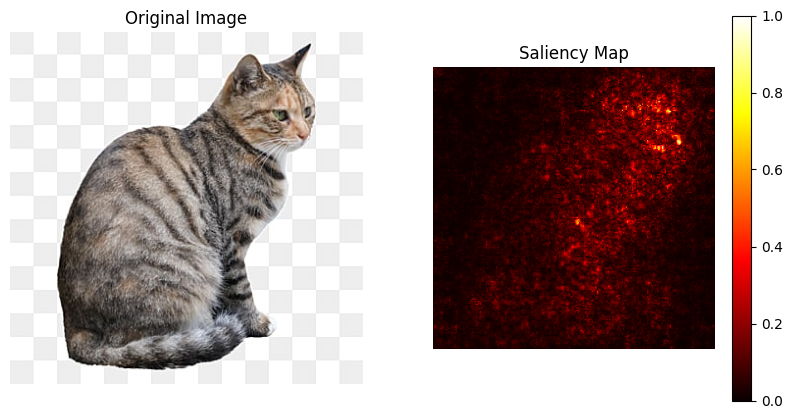

In [ ]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Загрузка предобученной модели
model = models.resnet18(pretrained=True)
model.eval()  # Переключаем в режим оценки

# Преобразования для изображения
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Загрузка изображения
image = Image.open("/content/котишка.jpg")  # Замените на свой путь
input_tensor = preprocess(image).unsqueeze(0)
input_tensor.requires_grad = True  # Включаем градиенты для входного тензора

# Прямой проход
output = model(input_tensor)
pred_class = output.argmax(dim=1).item()

# Обратный проход для целевого класса
model.zero_grad()
output[0, pred_class].backward()

# Получение градиентов входного изображения
gradients = input_tensor.grad[0]  # (3, H, W)
saliency_map = torch.abs(gradients).max(dim=0)[0]  # Берем максимум по каналам

# Нормализация для визуализации
saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())

# Преобразование в numpy и визуализация
saliency_map_np = saliency_map.detach().cpu().numpy()

# Визуализация
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(saliency_map_np, cmap='hot')
plt.title("Saliency Map")
plt.axis('off')
plt.colorbar()
plt.show()

Integrated Gradients

error: OpenCV(4.11.0) /io/opencv/modules/core/src/arithm.cpp:662: error: (-209:Sizes of input arguments do not match) The operation is neither 'array op array' (where arrays have the same size and the same number of channels), nor 'array op scalar', nor 'scalar op array' in function 'arithm_op'


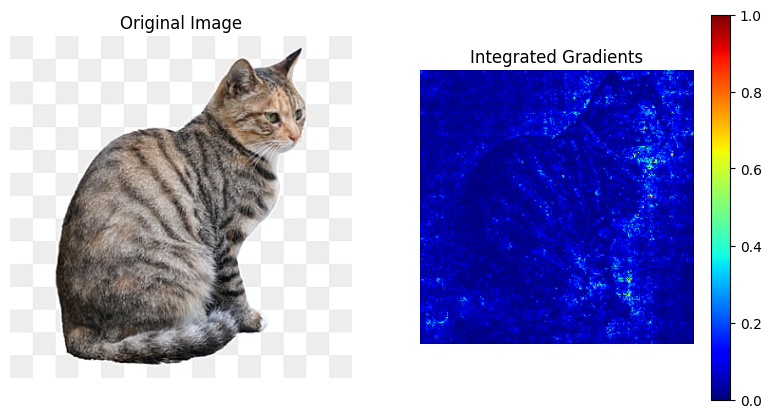

In [2]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Загрузка предобученной модели
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model.eval()

# Преобразования для изображения
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Функция для вычисления Integrated Gradients
def integrated_gradients(input_tensor, target_class, baseline=None, steps=50):
    if baseline is None:
        baseline = 0 * input_tensor  # Чёрное изображение как baseline

    # Генерация интерполированных изображений
    scaled_inputs = torch.cat([
        baseline + (float(i)/steps) * (input_tensor - baseline)
        for i in range(0, steps+1)
    ])

    # Вычисление градиентов
    scaled_inputs.requires_grad_(True)
    output = model(scaled_inputs)[:, target_class]
    gradients = torch.autograd.grad(output.sum(), scaled_inputs)[0]

    # Аппроксимация интеграла
    avg_gradients = torch.mean(gradients, dim=0, keepdim=True)
    integrated_grad = (input_tensor - baseline) * avg_gradients
    return integrated_grad

# Загрузка изображения
image = Image.open("/content/котишка.jpg").convert("RGB")  # Убедитесь в правильности пути
input_tensor = preprocess(image).unsqueeze(0)
input_tensor.requires_grad_(True)

# Вычисление IG
target_class = 281  # Класс "кошка" в ImageNet
ig = integrated_gradients(input_tensor, target_class)

# Постобработка для визуализации
ig = ig.squeeze().detach().numpy()
ig = np.abs(ig).sum(axis=0)  # Сумма по каналам RGB
ig = (ig - ig.min()) / (ig.max() - ig.min())  # Нормализация

# Визуализация
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(ig, cmap='jet')
plt.title("Integrated Gradients")
plt.colorbar()
plt.axis('off')

# Наложение heatmap на изображение
heatmap = np.uint8(255 * ig)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR), 0.5, heatmap, 0.5, 0)
superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)

plt.subplot(1, 3, 3)
plt.imshow(superimposed_img)
plt.title("Overlay")
plt.axis('off')
plt.show()

Grad-CAM

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 123MB/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will 

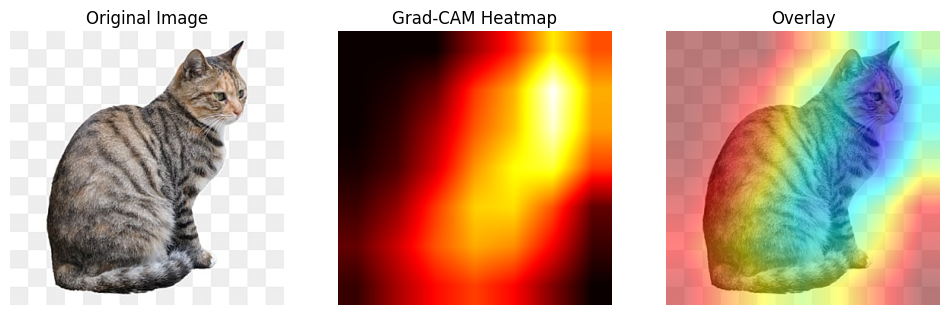

In [ ]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Загрузка предобученной модели
model = models.resnet18(pretrained=True)
model.eval()

# Выбор целевого слоя (последний сверточный слой ResNet)
target_layer = model.layer4[-1].conv2

# Хук для сохранения активаций и градиентов
activations = {}
gradients = {}

def forward_hook(module, input, output):
    activations['features'] = output.detach()

def backward_hook(module, grad_input, grad_output):
    gradients['features'] = grad_output[0].detach()

# Регистрация хуков
forward_handle = target_layer.register_forward_hook(forward_hook)
backward_handle = target_layer.register_backward_hook(backward_hook)

# Преобразования для изображения
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Загрузка изображения
image = Image.open("/content/котишка.jpg")  # Замените на свой путь
input_tensor = preprocess(image).unsqueeze(0)
input_tensor.requires_grad = True

# Прямой проход
output = model(input_tensor)
pred_class = output.argmax(dim=1).item()

# Обратный проход для целевого класса
model.zero_grad()
output[0, pred_class].backward()

# Получение активаций и градиентов
features = activations['features']  # [1, 512, 7, 7]
grads = gradients['features']  # [1, 512, 7, 7]

# Усреднение градиентов по пространственным измерениям
alpha = grads.mean(dim=(2, 3), keepdim=True)  # [1, 512, 1, 1]

# Взвешенная сумма активаций
grad_cam = (features * alpha).sum(dim=1, keepdim=True)  # [1, 1, 7, 7]

# Применение ReLU
grad_cam = torch.relu(grad_cam)

# Нормализация и интерполяция
grad_cam = grad_cam.squeeze().detach().cpu().numpy()
grad_cam = cv2.resize(grad_cam, (image.size[0], image.size[1]))
grad_cam = (grad_cam - grad_cam.min()) / (grad_cam.max() - grad_cam.min())

# Наложение heatmap на исходное изображение
image_np = np.array(image)
heatmap = cv2.applyColorMap(np.uint8(255 * grad_cam), cv2.COLORMAP_JET)
overlay = cv2.addWeighted(image_np, 0.5, heatmap, 0.5, 0)

# Визуализация
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(grad_cam, cmap='hot')
plt.title("Grad-CAM Heatmap")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(overlay)
plt.title("Overlay")
plt.axis('off')
plt.show()

# Удаление хуков
forward_handle.remove()
backward_handle.remove()

LIME

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=388c90d54d6f7ee5c38b3f91d5b532936d0d8045b6ae2c124d3501b6d362f1e9
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


  0%|          | 0/1000 [00:00<?, ?it/s]

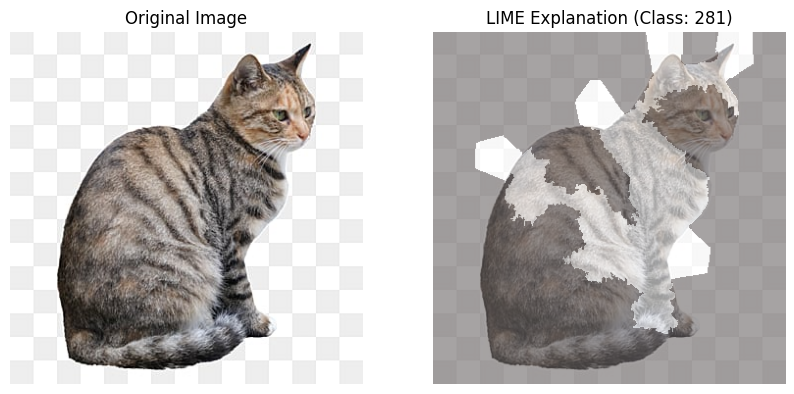

In [ ]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import slic
from lime import lime_image
import cv2

# Загрузка предобученной модели
model = models.resnet18(pretrained=True)
model.eval()

# Функция предсказания для LIME
def batch_predict(images):
    # Преобразование изображений в тензоры
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    batch = torch.stack([transform(img) for img in images], dim=0)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)

    with torch.no_grad():
        logits = model(batch)
    return logits.cpu().numpy()

# Загрузка изображения
image = Image.open("/content/котишка.jpg").convert("RGB")  # Замените на свой путь
image_np = np.array(image)

# Создание объяснителя LIME
explainer = lime_image.LimeImageExplainer()

# Генерация объяснения
explanation = explainer.explain_instance(
    image_np,
    batch_predict,
    top_labels=5,           # Топ-5 классов для объяснения
    hide_color=0,           # Цвет для маскирования (0 — чёрный)
    num_samples=1000,       # Количество пертурбаций
    segmentation_fn=slic    # Алгоритм сегментации (SLIC)
)

# Визуализация для топ-1 класса
label = explanation.top_labels[0]
temp, mask = explanation.get_image_and_mask(
    label,
    positive_only=True,    # Только позитивные вклады
    num_features=5,        # Топ-5 важных сегментов
    hide_rest=False        # Показывать всё изображение
)

# Наложение маски на изображение
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_np)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='hot', alpha=0.6)  # Тепловая карта
plt.imshow(image_np, alpha=0.4)          # Наложение исходного изображения
plt.title(f"LIME Explanation (Class: {label})")
plt.axis('off')
plt.show()

Layer-wise Relevance Propagation (LRP)

In [11]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Загрузка модели
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model.eval()

# Преобразования для изображения
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def lrp_resnet(model, input_tensor, target_class, epsilon=1e-6):
    # Прямой проход с сохранением активаций
    activations = []

    # Первый слой (conv1)
    x = model.conv1(input_tensor)
    x = model.bn1(x)
    x = model.relu(x)
    activations.append(('conv1', x))

    # MaxPool
    x = model.maxpool(x)
    activations.append(('maxpool', x))

    # Слои ResNet
    x = model.layer1(x)
    activations.append(('layer1', x))
    x = model.layer2(x)
    activations.append(('layer2', x))
    x = model.layer3(x)
    activations.append(('layer3', x))
    x = model.layer4(x)
    activations.append(('layer4', x))

    # Average Pooling
    x = model.avgpool(x)
    x = torch.flatten(x, 1)

    # Полносвязный слой
    output = model.fc(x)

    # Инициализация релевантности
    R = torch.zeros_like(output)
    R[0, target_class] = output[0, target_class]

    # Обратное распространение через FC слой
    W = model.fc.weight.data
    b = model.fc.bias.data
    Z = torch.mm(x, W.T) + b + epsilon * torch.sign(output)
    S = R / Z
    C = torch.mm(S, W)
    R_conv = x * C
    R_conv = R_conv.view(1, 512, 1, 1)  # Восстановление размерности

    # Обратное распространение через слои
    for name, activation in reversed(activations):
        if 'layer' in name or 'conv1' in name:
            # Для сверточных слоев
            if 'conv1' in name:
                layer = model.conv1
                bn = model.bn1
                # Учитываем BatchNorm
                gamma = bn.weight.data
                beta = bn.bias.data
                running_mean = bn.running_mean
                running_var = bn.running_var
                eps = bn.eps

                # Нормализация
                normalized = (activation - running_mean.view(1, -1, 1, 1)) / torch.sqrt(running_var.view(1, -1, 1, 1) + eps)
                # Scale and shift
                bn_output = gamma.view(1, -1, 1, 1) * normalized + beta.view(1, -1, 1, 1)

                Z = bn_output + epsilon * torch.sign(bn_output)
                S = R_conv / Z
                C = nn.functional.conv_transpose2d(S, layer.weight.data,
                                                  stride=layer.stride,
                                                  padding=layer.padding)
                R_conv = input_tensor * C
            else:
                # Для residual блоков
                layer = getattr(model, name)
                for block in reversed(layer):
                    # Упрощенная обработка residual блока
                    identity = activation
                    conv1 = block.conv1
                    conv2 = block.conv2

                    # Обратное распространение через второй conv
                    Z = conv2(activation) + epsilon * torch.sign(conv2(activation))
                    S = R_conv / Z
                    C = nn.functional.conv_transpose2d(S, conv2.weight.data,
                                                      stride=conv2.stride,
                                                      padding=conv2.padding)
                    R_conv = activation * C

                    # Обратное распространение через первый conv
                    Z = conv1(activation) + epsilon * torch.sign(conv1(activation))
                    S = R_conv / Z
                    C = nn.functional.conv_transpose2d(S, conv1.weight.data,
                                                      stride=conv1.stride,
                                                      padding=conv1.padding)
                    R_conv = activation * C

                    # Учет skip connection
                    R_conv = R_conv + identity * R_conv
        elif 'maxpool' in name:
            # Простая обратная проекция для maxpool
            R_conv = nn.functional.interpolate(R_conv, scale_factor=2, mode='nearest')

    return R_conv

# Загрузка изображения
image = Image.open("котишка.jpg").convert("RGB")
input_tensor = preprocess(image).unsqueeze(0)
input_tensor.requires_grad_(True)

# Вычисление LRP
target_class = 281  # Класс "кошка" в ImageNet
relevance = lrp_resnet(model, input_tensor, target_class)

# Постобработка для визуализации
relevance_map = relevance.squeeze().sum(dim=0).detach().numpy()
relevance_map = (relevance_map - relevance_map.min()) / (relevance_map.max() - relevance_map.min())

# Визуализация
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(relevance_map, cmap='hot')
plt.title("LRP Relevance Map")
plt.colorbar()
plt.axis('off')
plt.show()

RuntimeError: Given groups=1, weight of size [512, 256, 3, 3], expected input[1, 512, 7, 7] to have 256 channels, but got 512 channels instead

In [14]:
def lrp_resnet(model, input_tensor, target_class, epsilon=1e-6):
    activations = []

    # Прямой проход для сохранения активаций
    def hook(module, input, output):
        activations.append(output)

    hooks = []
    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.ReLU, nn.MaxPool2d, nn.AvgPool2d, nn.BatchNorm2d)):
            hooks.append(module.register_forward_hook(hook))

    with torch.no_grad():
        x = model.conv1(input_tensor)
        x = model.bn1(x)
        x = model.relu(x)
        x = model.maxpool(x)

        x = model.layer1(x)
        x = model.layer2(x)
        x = model.layer3(x)
        x = model.layer4(x)

        x = model.avgpool(x)
        x = torch.flatten(x, 1)
        output = model.fc(x)

    # Удаляем хуки
    for h in hooks:
        h.remove()

    # Инициализируем R
    R = torch.zeros_like(output)
    R[0, target_class] = output[0, target_class]

    # Обратное распространение через FC
    # Обратное распространение через FC
    W = model.fc.weight.data
    b = model.fc.bias.data
    Z = torch.mm(x, W.T) + b + epsilon * torch.sign(R)
    S = R / Z
    C = torch.mm(S, W)

    # --- Вот здесь была ошибка ---
    target_shape = activations[-3].shape
    R = C.view(target_shape)  # Теперь корректно восстанавливаем форму
    # Индекс активаций
    idx = len(activations) - 1

    # Проходим в обратном порядке по слоям
    for name, module in reversed(list(model.named_children())):
        if name in ['layer4', 'layer3', 'layer2', 'layer1']:
            layer = getattr(model, name)
            for block in reversed(layer):
                # Обратное распространение через второй conv
                R = simple_lrp(block.conv2, block.bn2, R, activations[idx-2], epsilon)
                idx -= 1
                R = simple_lrp(block.conv1, block.bn1, R, activations[idx-2], epsilon)
                idx -= 1

                # Skip connection
                if block.downsample is not None:
                    R_skip = simple_lrp(block.downsample[0], block.downsample[1], R, activations[idx-2], epsilon)
                    idx -= 1
                    R = R + R_skip
                else:
                    R = R + activations[idx-2] * (R.sum() / (activations[idx-2].sum() + epsilon))
                idx -= 1

        elif name == 'maxpool':
            R = R  # пропускаем или делаем nearest upsampling
        elif name == 'relu':
            R = R * (activations[idx] > 0).float()
            idx -= 1
        elif name == 'bn1':
            continue
        elif name == 'conv1':
            R = simple_lrp(model.conv1, model.bn1, R, input_tensor, epsilon)
            break

    return R


# Упрощённый LRP для одного сверточного слоя с BatchNorm
def simple_lrp(conv, bn, R, A_prev, epsilon=1e-6):
    W = conv.weight.data
    b = conv.bias.data

    # Forward pass
    Z = conv(A_prev)
    Z = bn(Z)
    Z = Z + epsilon * torch.sign(Z)

    S = R / Z
    grad = torch.nn.functional.conv_transpose2d(S, W, stride=conv.stride, padding=conv.padding)
    C = grad
    return A_prev * C

In [16]:
# Загрузите изображение
image = Image.open("/content/котишка.jpg").convert("RGB")
input_tensor = preprocess(image).unsqueeze(0)

# Примените LRP
relevance = lrp_resnet(model, input_tensor, target_class=14)

# Постобработка
relevance_map = relevance.squeeze().sum(dim=0).detach().numpy()
relevance_map = (relevance_map - relevance_map.min()) / (relevance_map.max() - relevance_map.min())

# Отобразите результат
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(relevance_map, cmap='hot')
plt.title("LRP Relevance Map")
plt.colorbar()
plt.axis('off')
plt.show()

RuntimeError: shape '[1, 512, 7, 7]' is invalid for input of size 512